In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# Helper functions

def normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data, min_val, max_val

def create_sequences(data, length):
    X, y = [], []
    for i in range(length, len(data) - 1):
        X.append(data[i-length:i])
        y.append(data[i+1])
    return np.array(X), np.array(y)
def denormalize(data, min_val, max_val):
    return data * (max_val - min_val) + min_val

In [3]:
# Data fetching and preprocessing for TCS
tcs_data = yf.download('TCS.NS', start='2020-01-01')

# Display the first few rows of the data
print(tcs_data.head())


[*********************100%***********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-01-01  2168.000000  2183.899902  2154.000000  2167.600098  1980.292603   
2020-01-02  2179.949951  2179.949951  2149.199951  2157.649902  1971.202393   
2020-01-03  2164.000000  2223.000000  2164.000000  2200.649902  2010.486572   
2020-01-06  2205.000000  2225.949951  2187.899902  2200.449951  2010.304688   
2020-01-07  2200.500000  2214.649902  2183.800049  2205.850098  2015.238037   

             Volume  
Date                 
2020-01-01  1354908  
2020-01-02  2380752  
2020-01-03  4655761  
2020-01-06  3023209  
2020-01-07  2429317  


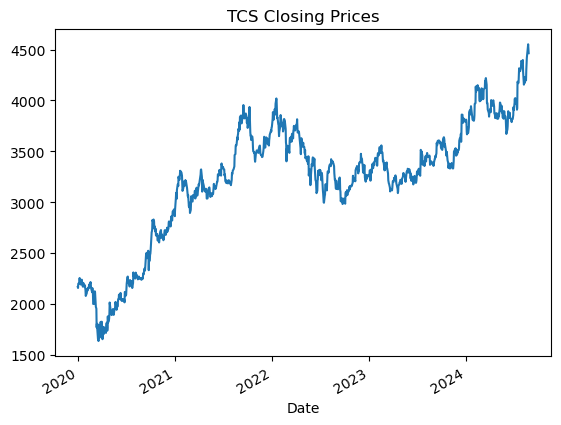

In [4]:
# Plotting the closing prices
tcs_data['Close'].plot(title='TCS Closing Prices')
plt.show()

In [5]:
# Removing missing values
tcs = tcs_data.dropna()

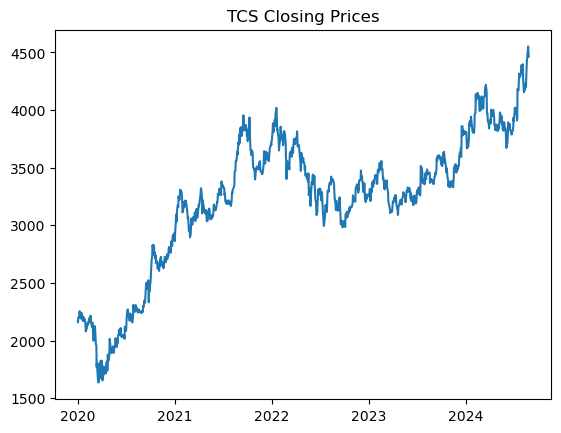

In [6]:
# Stationarity test for closing price
tcs_close = tcs['Close']
plt.plot(tcs_close)
plt.title('TCS Closing Prices')
plt.show()

In [7]:
result = adfuller(tcs_close)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.0832980521363
p-value: 0.7216862851427286


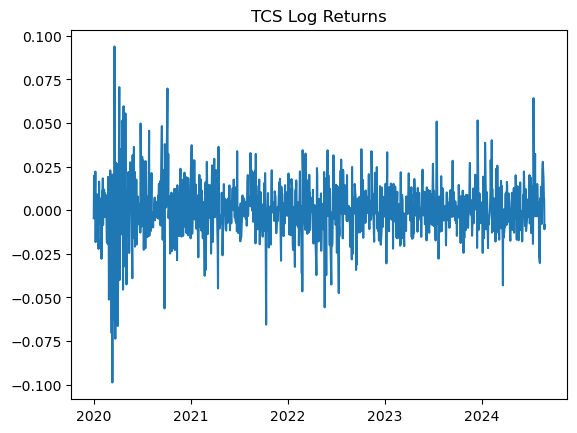

In [8]:
# Stationarity test for daily log returns
tcs_log_price = np.log(tcs_close)
tcs_log_returns = tcs_close.pct_change().apply(lambda x:np.log(1 + x)).dropna()
plt.plot(tcs_log_returns)
plt.title('TCS Log Returns')
plt.show()


In [9]:
result = adfuller(tcs_log_returns)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -12.999355951320187
p-value: 2.7076794355741945e-24


In [10]:
# Splitting train and test data
test_size = int(len(tcs_log_price) / 10)
train, test = tcs_log_price[:-test_size],tcs_log_price[-test_size:]

In [11]:
# ARMA Model testing
model_2020 = ARIMA(train, order=(1, 1, 1)).fit()
print(model_2020.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1035
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2819.989
Date:                Sat, 24 Aug 2024   AIC                          -5633.978
Time:                        11:52:50   BIC                          -5619.155
Sample:                             0   HQIC                         -5628.354
                               - 1035                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2222      0.237      0.938      0.348      -0.242       0.687
ma.L1         -0.2983      0.230     -1.295      0.195      -0.750       0.153
sigma2         0.0003   5.88e-06     42.584      0.0

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [12]:
# Fetch data for 2021
tcs_data_2021 = yf.download('TCS.NS', start='2021-01-01')

[*********************100%***********************]  1 of 1 completed


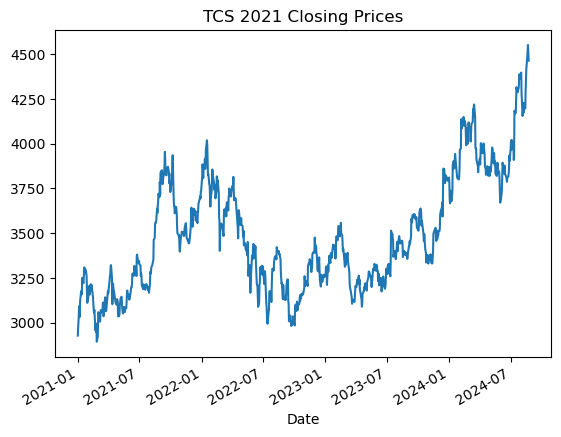

In [13]:
# Plot closing price
tcs_data_2021['Close'].plot(title='TCS 2021 Closing Prices')
plt.show()


In [14]:
# Removing missing values
tcs_2021 = tcs_data_2021.dropna()

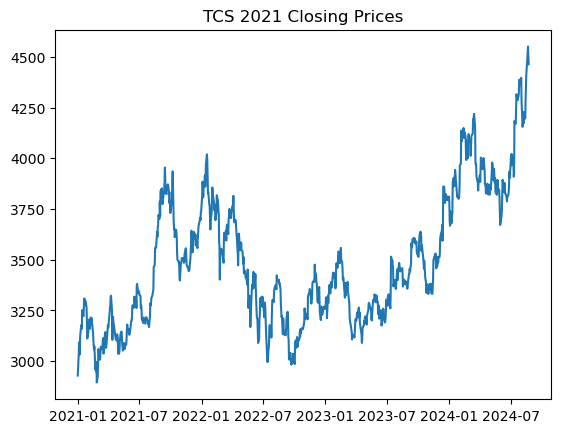

In [15]:
# Stationarity test for closing price
tcs_close_2021 = tcs_2021['Close']
plt.plot(tcs_close_2021)
plt.title('TCS 2021 Closing Prices')
plt.show()


In [16]:
result = adfuller(tcs_close_2021)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -1.4703173772948694
p-value: 0.5481404964002202


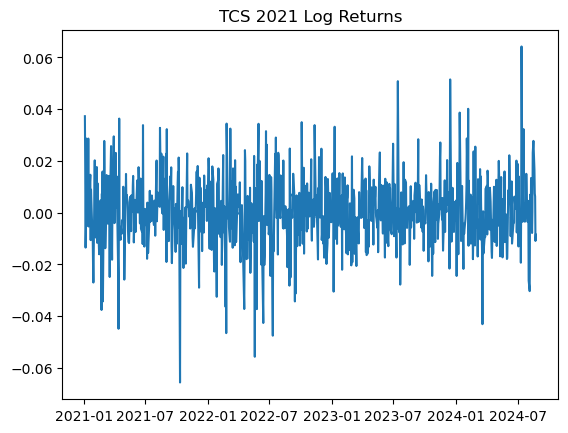

In [17]:
# Stationarity test for daily log returns
tcs_log_price_2021 = np.log(tcs_close_2021)
tcs_log_returns_2021 =tcs_close_2021.pct_change().apply(lambda x: np.log(1 + x)).dropna()
plt.plot(tcs_log_returns_2021)
plt.title('TCS 2021 Log Returns')
plt.show()

In [18]:
result = adfuller(tcs_log_returns_2021)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -29.527005178705682
p-value: 0.0


In [19]:
# Splitting train and test data
test_size = int(len(tcs_log_price_2021) / 10)
train_2021, test_2021 = tcs_log_price_2021[:-test_size], tcs_log_price_2021[-test_size:]

In [20]:
# ARMA Model testing
model_2021 = ARIMA(train_2021, order=(1, 1, 1)).fit()
print(model_2021.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  810
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2347.380
Date:                Sat, 24 Aug 2024   AIC                          -4688.760
Time:                        11:53:21   BIC                          -4674.673
Sample:                             0   HQIC                         -4683.351
                                - 810                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5506      3.073      0.179      0.858      -5.473       6.574
ma.L1         -0.5443      3.087     -0.176      0.860      -6.595       5.506
sigma2         0.0002   6.14e-06     28.770      0.0

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [21]:
# Forecasting
forecast_2021 = model_2021.get_forecast(steps=len(test_2021))
forecast_mean_2021 = forecast_2021.predicted_mean

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [22]:
# Accuracy metrics
mse_2021 = np.mean((forecast_mean_2021 - test_2021) ** 2)
print(f'MSE for 2021 model: {mse_2021}')

MSE for 2021 model: nan


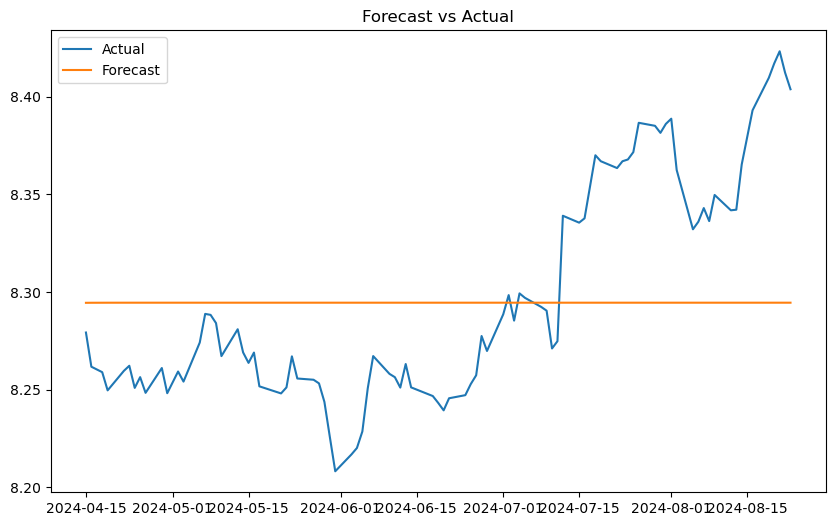

In [23]:
# Plotting the forecast
plt.figure(figsize=(10, 6))
plt.plot(test_2021.index, test_2021, label='Actual')
plt.plot(test_2021.index, forecast_mean_2021, label='Forecast')
plt.legend()
plt.title('Forecast vs Actual')
plt.show()

In [24]:
# GARCH model fitting
model_garch = arch_model(model_2021.resid, vol='Garch', p=3, q=2)
model_garch_fit = model_garch.fit()
print(model_garch_fit.summary())

Iteration:      1,   Func. Count:      9,   Neg. LLF: 6675852.27281248
Iteration:      2,   Func. Count:     27,   Neg. LLF: 341132.541432615
Iteration:      3,   Func. Count:     41,   Neg. LLF: -1132.3313644946359
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1132.331396832179
            Iterations: 7
            Function evaluations: 41
            Gradient evaluations: 3
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1132.33
Distribution:                  Normal   AIC:                          -2250.66
Method:            Maximum Likelihood   BIC:                          -2217.78
                                        No. Observations:                  810
Date:                Sa

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07873. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [25]:
# Function to normalize data using Min-Max scaling
from sklearn.preprocessing import MinMaxScaler

def normalize(data):
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data.values.reshape(-1, 1))
    return normalized_data, scaler


def create_sequences(data, length):
    X, y = [], []
    for i in range(length, len(data)):
        X.append(data[i-length:i])
        y.append(data[i])
    return np.array(X), np.array(y)


In [26]:
# Normalize train and test data
normalized_train, scaler_train = normalize(pd.DataFrame(train))
normalized_test, scaler_test = normalize(pd.DataFrame(test))

In [27]:
# Use normalized data to create sequences
sequence_length = 30 # Window size
X_train, y_train = create_sequences(normalized_train, sequence_length)
X_test, y_test = create_sequences(normalized_test, sequence_length)

In [28]:
# Define and compile the LSTM model
from tensorflow.keras.optimizers import Adam
model = Sequential([LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),LSTM(50),Dense(1)])
model.compile(loss='mean_squared_error', optimizer=Adam())

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
# Train the LSTM model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
    verbose=1)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.1361 - val_loss: 0.0017
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0052 - val_loss: 0.0011
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0016 - val_loss: 9.2327e-04
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0019 - val_loss: 9.9428e-04
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0017 - val_loss: 8.1564e-04
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014 - val_loss: 7.6507e-04
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0013 - val_loss: 7.7421e-04
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0015 - val_loss: 8.5677e-04
Epoch 12/100
26/26 ━━━━━━━━━

In [30]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0086 
Test Loss: 0.010108498856425285


In [31]:
# Make predictions
predictions = model.predict(X_test)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


In [32]:
# Denormalize predictions and actual values
predicted_denormalized = scaler_test.inverse_transform(predictions)
actual_denormalized = scaler_test.inverse_transform(y_test.reshape(-1,1))


In [33]:
# Combine actual and predicted values into a data frame for plotting
results = pd.DataFrame({'time': range(len(y_test)), 'actual':
actual_denormalized.flatten(), 'predicted':
predicted_denormalized.flatten()})

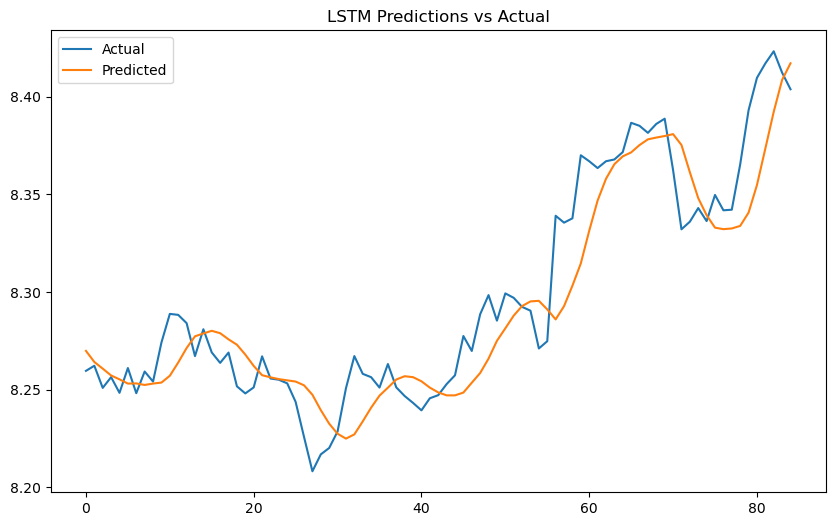

In [34]:
# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(results['time'], results['actual'], label='Actual')
plt.plot(results['time'], results['predicted'], label='Predicted')
plt.legend()
plt.title('LSTM Predictions vs Actual')
plt.show()


In [35]:
# Calculate MAE, MSE, RMSE
mae = np.mean(np.abs(predicted_denormalized - actual_denormalized))
mse = np.mean((predicted_denormalized - actual_denormalized) ** 2)
rmse = np.sqrt(mse)
print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}')

MAE: 0.016437875893411218, MSE: 0.0004672915072582446, RMSE: 0.021616926406366022


In [36]:
# Function to create a lagged data frame
def create_lagged_df(series, max_lag):
    lagged_df = pd.concat([series.shift(i) for i in range(1, max_lag + 1)], axis=1)
    lagged_df.columns = [f'lag_{i}' for i in range(1, max_lag + 1)]
    lagged_df['t'] = series
    return lagged_df.dropna()


In [37]:
# Create lagged data frame with maximum lag of 20
max_lag = 20
lagged_df = create_lagged_df(pd.Series(model_2021.resid), max_lag)

In [38]:
# Separate features (X) and target (y)
X = lagged_df.iloc[:, :-1]
y = lagged_df.iloc[:, -1]

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=1)
rf_model.fit(X, y)

# Get the feature importances
importance_scores = rf_model.feature_importances_


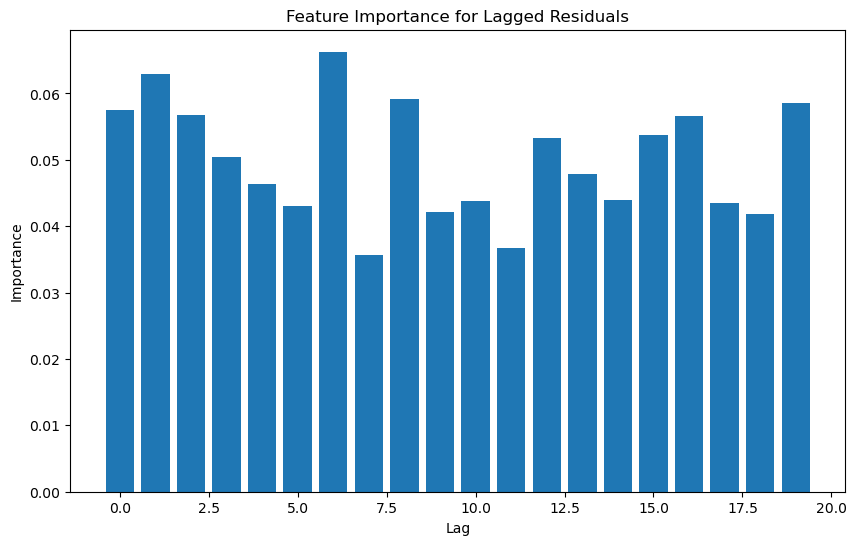

In [39]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(max_lag), importance_scores)
plt.xlabel('Lag')
plt.ylabel('Importance')
plt.title('Feature Importance for Lagged Residuals')
plt.show()


In [40]:
# Normalize train and test data
normalized_train, scaler_train = normalize(pd.DataFrame(train))
normalized_test, scaler_test = normalize(pd.DataFrame(test))


In [41]:
# Use normalized data to create sequences
sequence_length = 8 # Window size
X_train, y_train = create_sequences(normalized_train, sequence_length)
X_test, y_test = create_sequences(normalized_test, sequence_length)

In [42]:
# Define and compile the LSTM model
model = Sequential([LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),LSTM(50),Dense(1)])


C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
model.compile(loss='mean_squared_error', optimizer=Adam())

In [44]:
# Train the LSTM model
history = model.fit(X_train, y_train, epochs=100, batch_size=32,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=10)], verbose=1)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1903 - val_loss: 0.0230
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0094 - val_loss: 0.0048
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018 - val_loss: 5.7125e-04
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011 - val_loss: 5.6490e-04
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.4347e-04 - val_loss: 5.6784e-04
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - val_loss: 5.4653e-04
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 5.5111e-04
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - val_loss: 6.5056e-04
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.8495e-04 - val_loss: 6.4483e-04
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - val_loss: 5.8345e-04
Epoch 12/100
2